In [ ]:
import torch
import sys, os
notebook_path = os.getcwd()  # Get the current working directory
parent_directory = os.path.dirname(notebook_path)  # Get the parent directory
sys.path.append(parent_directory)
# from models.resnet import ResNet18
# from models.vggnet import ExpVGG16_BN
from models.utils import eager_quantize_model,fx_quantize_model,MeasureExecutionTime
from models.conv import fuse_module
from models.mobilenetv2 import mobilenet_v2,mobilenet_v2_qint8,mobilenet_v2_dc
# 设置量化引擎为QNNPACK
torch.backends.quantized.engine = 'qnnpack'

x = torch.rand(16,3,224,224)
model =mobilenet_v2()
q_model = mobilenet_v2_qint8()
dc_model = mobilenet_v2_dc(5,5)
with MeasureExecutionTime(measure_name="Float"):
    out= model(x)

with MeasureExecutionTime(measure_name="Qint8"):
    out= q_model(x)

with MeasureExecutionTime(measure_name="DC"):
    out= dc_model(x)

# vgg16bn = ExpVGG16_BN()
# convert_to_direct_conv2d(fake_fuse_module_bn_relu(resnet18),3,3, module_type=nn.Conv2d)
# vgg16bn(torch.rand(1,3,224,224))


Float time: 3.0160 s
Qint8 time: 881.0310 ms
DC time: 1.0148 s


In [1]:
# model(torch.rand(1,3,224,224))
def test_packed_weights(values,guard_bits=13):
    values=[]
    for i in range(3):
        values.append((values>>(i*guard_bits))&((1<<guard_bits)-1))
    return values
test_packed_weights(8+1<<13+2<<26,13)   

NameError: name 'model' is not defined

In [ ]:
# from models.vggnet import VGG16_BN_qint8
# vgg16bn_qint8 = VGG16_BN_qint8()
# vgg16bn_qint8(torch.rand(1,3,224,224))
# vgg16bn_qint8
# from models.utils import eager_quantize_model,fx_quantize_model
from models.conv import fuse_module
# vgg16bn.eval()
model = fuse_module(vgg16bn)
model

ExpVGG(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (features): Sequential(
    (0): AlignW()
    (1): ConvReLU2d(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (2): Identity()
    (3): Identity()
    (4): AlignW()
    (5): ConvReLU2d(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (6): Identity()
    (7): Identity()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AlignW()
    (10): ConvReLU2d(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (11): Identity()
    (12): Identity()
    (13): AlignW()
    (14): ConvReLU2d(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (15): Identity()
    (16): Identity()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [ ]:
# model
# import sys, os
# notebook_path = os.getcwd()  # Get the current working directory
# parent_directory = os.path.dirname(notebook_path)  # Get the parent directory
# sys.path.append(parent_directory)
# from models.utils import eager_quantize_model,fx_quantize_model
# q_model = eager_quantize_model(model,shape=(1,3,224,224))
# import torch
# torch.__version__
# vgg16bn_qint8

In [ ]:
from models.vggnet import ExpVGG16_BN_qint8
vgg16bn_qint8 = ExpVGG16_BN_qint8()

/data/newhome/gongcheng/.local/lib/python3.9/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


In [ ]:
from torch.ao.nn.intrinsic.quantized.modules.conv_relu import ConvReLU2d
# isinstance(, type(vgg16bn_qint8.features))
type(vgg16bn_qint8.features[0])
# vgg16bn_qint8
import time
def test_time(layer,input,warmup=4,repeat = 10):
    for _ in range(warmup):
        output = layer(input)
    
    elapsed_time = 0
    for _ in range(repeat):
        start = time.perf_counter()
        output = layer(input)
        elapsed_time += time.perf_counter() - start
    return output, elapsed_time/repeat

import torch
def get_module_input_output_shape(model, 
                                  layer_types=(torch.nn.Conv2d,), 
                                  first_input_shape=(1,3,224,224),
                                  qunantize_input=False,
                                  ):
    """
    Get the input shape for a specified layer in a PyTorch model.

    Parameters:
    - model: The PyTorch model.
    - layer_name: The name of the layer for which to find the input shape.
    - input_shape: The shape of the input to feed to the model for the forward pass.

    Returns:
    - The input shape to the specified layer.
    """
    # Variable to store the input shape
    captured_input_shapes = []
    captured_output_shapes = []
    captured_layers = []
    captured_layer_names = []
    handles = []

    # Hook function to capture the input shape
    def hook_fn(module, input, output):
        # nonlocal captured_shape
        captured_input_shapes.append(input[0].shape)
        captured_output_shapes.append(output.shape)
        # captured_layers.append(module)

    # Find and attach the hook to the specified layer
    for name, layer in model.named_modules():
        # print(layer_types)
        if isinstance(layer, layer_types):
            handles.append(layer.register_forward_hook(hook_fn))
            captured_layer_names.append(name)
            captured_layers.append(layer)
            # break
        # else:
        #     raise ValueError(f"Layer {layer_types} not found in the model.")

    # Create a dummy input and perform a forward pass to trigger the hook
    dummy_input = torch.rand(first_input_shape)
    if qunantize_input:
        quant = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8) # torch.quantization.QuantStub()
        dummy_input = quant(dummy_input)
    model(dummy_input)

    # Remove the hook
    # handle.remove()
    for handle in handles:
        handle.remove()

    return captured_layer_names, captured_layers, captured_input_shapes, captured_output_shapes

from models.conv import DirectConv2d,PadConv2d
def create_direct_conv2d_from(module, W_bits=3, A_bits=3, type="directconv",
                              prepare_func=lambda x: x.int(),
                             post_func=lambda x: x,
                             copy_weight = False,
                             quantize = False):
    __types__ = ["directconv","padconv"]
    if type not in __types__:
        raise ValueError(f"Only support {__types__} for type, but got {type}")
    dc_layer = None
    if module.kernel_size[0]==3 \
                and module.stride[0]==1 and module.dilation[0]==1:
        if type == "directconv":
            dc_layer = DirectConv2d(module.in_channels, 
                        module.out_channels, 
                        module.kernel_size[0], 
                        W_bits, A_bits, True,
                        prepare_func, post_func)
        elif type == "padconv":
            dc_layer = PadConv2d(module.in_channels, 
                                module.out_channels, 
                                module.kernel_size[0], 
                                W_bits = W_bits, A_bits = A_bits, 
                                stride= module.stride[0], 
                                dilation=module.dilation[0])
    return dc_layer

def replace_module(model, path, new_module):
    """
    递归地替换模型中的模块。
    :param model: 要修改的模型。
    :param path: 要替换的模块的路径，以点分隔。
    :param new_module: 新的模块对象。
    """
    path_list = path.split('.')
    for name in path_list[:-1]:
        model = getattr(model, name)
    setattr(model, path_list[-1], new_module)

import copy

def TestandReplace_VGGlayer(model, W_A_bit,layer_names, layers, input_shapes):
    repeat = 4
    warmup = 2
    W_bits, A_bits = W_A_bit
    replace_layers = []
    start_layer_list = []
    end_layer_list = []
    end_layer_names = []
    pre_replace_layer = None
    for i,layer in enumerate(layers):
        # print(layer)
        # print(input_shapes[i])
        # print(output_shapes[i])
        # if isinstance(layer, ConvReLU2d):
        # 测试以下两个层的运行耗时
        inp = torch.rand(input_shapes[i])
        quant_inp = torch.quantize_per_tensor(inp, scale=1.0, zero_point=0, dtype=torch.quint8)
        direct_conv2d_layer = create_direct_conv2d_from(layer, W_bits, A_bits,type="directconv")
        # pad_conv2d_layer = create_direct_conv2d_from(layer, W_bits, A_bits,type="wrappedconv",quantize = True)
        out1,time1 = test_time(layer, quant_inp, warmup=warmup,repeat = repeat)
        out2,time2 = test_time(direct_conv2d_layer, inp, warmup=warmup,repeat = repeat)
        # out3,time3 = test_time(pad_conv2d_layer, inp)
        print(f"{i}-th layer:")
        print(f"\teagerqint8 layer  time: {time1}")
        print(f"\tdirectconv layer  time: {time2}")
        
        if (time1>time2): # 将原始layer替换为directconv
            print(f"\t Layer {layer_names[i]}: directconv W{W_bits}A{A_bits} is faster than eagerqint8 by {time1-time2:.4}s, replace it!")
            # setattr(model, layer_names[i], direct_conv2d_layer)
            replace_module(model, layer_names[i], direct_conv2d_layer)
            replace_layers.append(direct_conv2d_layer)
            if pre_replace_layer is None:
                pre_replace_layer = direct_conv2d_layer
                start_layer_list.append(pre_replace_layer)
                layer_names.append(layer_names[i])
        else:
            print(f"\t Layer {layer_names[i]}: eagerqint8 is faster than directconv W{W_bits}A{A_bits}, keep it!")
            if pre_replace_layer is not None:
                end_layer_list.append(pre_replace_layer)
                pre_replace_layer = None
                # print(end_layer_name = layer_names[i])
        # print(f"\twrappedconv layer  time: {time3}")
    # 记得把最后一层的输出改为qint8
    end_layer_list.append(replace_layers[-1])
    for layer in start_layer_list:
        layer.prepare_func = lambda x: x.dequantize().int()
    # model.features[10].prepare_func = lambda x: x.dequantize().int()
    for layer in end_layer_list:
        layer.post_func = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)
    # model.features[53].post_func = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)
    return model

def VGG_BN_directconv(W_A_bit_list=[3,3], name = "VGG16",shape=(1,3,224,224),engine_name = 'qnnpack'):
    # model = VGG_BN_qint8(name,shape,engine_name)
    model = copy.deepcopy(vgg16bn_qint8)
    # 测试每一个量化卷积层和对应的directconv的耗时，并替换计算更快的卷积层
    
    layer_names, layers, input_shapes, output_shapes = get_module_input_output_shape(model, 
                                                                        qunantize_input=True,
                                                                        layer_types=(ConvReLU2d,), 
                                                                        first_input_shape=shape)
    # repeat = 4
    # warmup = 2
    # for i,layer in enumerate(layers):
    #     # print(layer)
    #     # print(input_shapes[i])
    #     # print(output_shapes[i])
    #     # if isinstance(layer, ConvReLU2d):
    #     # 测试以下两个层的运行耗时
    #     inp = torch.rand(input_shapes[i])
    #     quant_inp = torch.quantize_per_tensor(inp, scale=1.0, zero_point=0, dtype=torch.quint8)
    #     direct_conv2d_layer = create_direct_conv2d_from(layer, W_bits, A_bits,type="directconv")
    #     # pad_conv2d_layer = create_direct_conv2d_from(layer, W_bits, A_bits,type="wrappedconv",quantize = True)
    #     out1,time1 = test_time(layer, quant_inp, warmup=warmup,repeat = repeat)
    #     out2,time2 = test_time(direct_conv2d_layer, inp, warmup=warmup,repeat = repeat)
    #     # out3,time3 = test_time(pad_conv2d_layer, inp)
    #     print(f"{i}-th layer:")
    #     print(f"\teagerqint8 layer  time: {time1}")
    #     print(f"\tdirectconv layer  time: {time2}")
    #     if (time1>time2): # 将原始layer替换为directconv
    #         print(f"\t Layer {layer_names[i]}: directconv is faster than eagerqint8 by {time1-time2:.4}s, replace it!")
    #         # setattr(model, layer_names[i], direct_conv2d_layer)
    #         replace_module(model, layer_names[i], direct_conv2d_layer)
    #     else:
    #         print(f"\t Layer {layer_names[i]}: eagerqint8 is faster than directconv, keep it!")
    #     # print(f"\twrappedconv layer  time: {time3}")
    # model.features[10].prepare_func = lambda x: x.dequantize().int()
    # model.features[53].post_func = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)
    models = [copy.deepcopy(model) for _ in W_A_bit_list]
    for m,W_A_bits in zip(models,W_A_bit_list):
        m = TestandReplace_VGGlayer(m, W_A_bits, layer_names, layers, input_shapes)
    return models
# layer_names, layers, input_shapes, output_shapes = get_module_input_output_shape(vgg16bn_qint8, 
#                                                             qunantize_input=True,
#                                                             layer_types=(ConvReLU2d,), 
#                                                             first_input_shape=(1,3,224,224))

W_A_bit_list = [[3,3],[2,2]]
vgg16bn_directconvs = VGG_BN_directconv(W_A_bit_list=W_A_bit_list,shape=(1,3,224,224))

0-th layer:
	eagerqint8 layer  time: 0.02710368880070746
	directconv layer  time: 0.052724953508004546
	 Layer features.1: eagerqint8 is faster than directconv W3A3, keep it!
1-th layer:
	eagerqint8 layer  time: 0.15064069454092532
	directconv layer  time: 0.18505668843863532
	 Layer features.5: eagerqint8 is faster than directconv W3A3, keep it!
2-th layer:
	eagerqint8 layer  time: 0.07917620684020221
	directconv layer  time: 0.08322201180271804
	 Layer features.10: eagerqint8 is faster than directconv W3A3, keep it!
3-th layer:
	eagerqint8 layer  time: 0.18105861451476812
	directconv layer  time: 0.1408108095638454
	 Layer features.14: directconv W3A3 is faster than eagerqint8 by 0.04025s, replace it!
4-th layer:
	eagerqint8 layer  time: 0.07793318771291524
	directconv layer  time: 0.06350989069323987
	 Layer features.19: directconv W3A3 is faster than eagerqint8 by 0.01442s, replace it!
5-th layer:
	eagerqint8 layer  time: 0.14332643075613305
	directconv layer  time: 0.1141497475327

In [ ]:
models[0](quant(torch.rand(4,3,224,224)))

tensor([[-0.0134, -0.0030, -0.0022,  ..., -0.0090,  0.0194, -0.0134],
        [-0.0134, -0.0030, -0.0022,  ..., -0.0090,  0.0194, -0.0134],
        [-0.0134, -0.0030, -0.0022,  ..., -0.0090,  0.0194, -0.0134],
        [-0.0134, -0.0030, -0.0022,  ..., -0.0090,  0.0194, -0.0134]],
       size=(4, 1000), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0003731698670890182,
       zero_point=64)

In [ ]:
# quant = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8) 
# vgg16bn_directconv(quant(torch.rand(1,3,224,224)))
batch_sizes = [1,2,4,8]
perf_comp = {}
model_names = [f"vgg16bn_directconv_W{v[0]}A{v[0]}" for v in W_A_bit_list]
models = vgg16bn_directconvs
# models[0].features[53].post_func = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)
# models[1].features[53].post_func = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)
# models[2].features[53].post_func = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)
import time
for b in batch_sizes:
    print(f"Batch size: {b}")
    perf_comp[b] = []
    for i, m in enumerate(models):
        # out0,time0 = test_time(vgg16bn, torch.rand(b,3,224,224),1,2)
        # out1,time1 = test_time(vgg16bn_qint8, quant(torch.rand(b,3,224,224)),1,2)
        out,ecaplated_time = test_time(m, quant(torch.rand(b,3,224,224)),2,4)
        # fps0 = b/time0
        # fps1 = b/time1
        fps = b/ecaplated_time
        res=[ecaplated_time,fps]
        # print(f"\tvgg16bn_float: latency: {time0:.4}s, fps: {fps0:.4} ")
        # print(f"\tvgg16bn_qint8: latency: {time1:.4}s, fps: {fps1:.4} ")
        print(f"\t{model_names[i]}: latency: {ecaplated_time:.4}s, fps: {fps:.4} ")
        perf_comp[b].append(fps)


Batch size: 1
	model[0]: latency: 1.354s, fps: 0.7387 
	model[1]: latency: 1.432s, fps: 0.6981 
Batch size: 2
	model[0]: latency: 2.442s, fps: 0.819 
	model[1]: latency: 2.22s, fps: 0.9011 
Batch size: 4
	model[0]: latency: 3.631s, fps: 1.102 
	model[1]: latency: 3.591s, fps: 1.114 
Batch size: 8
	model[0]: latency: 6.342s, fps: 1.261 
	model[1]: latency: 6.312s, fps: 1.267 


In [ ]:
# out2,time2 = test_time(vgg16bn_directconv, quant(torch.rand(1,3,224,224)),2,4)
# time2

import numpy as np
perf_comp_b = {b:int(b)*np.array(perf_comp[b][3:]) for b in batch_sizes}
perf_comp_b

{1: array([0.20987828, 0.71625762, 0.74900621]),
 2: array([0.19773487, 0.74032495, 0.92111343]),
 4: array([0.13423196, 0.94447353, 1.01818722]),
 8: array([0.13565108, 1.0991052 , 1.32400622])}

In [ ]:
qnnpack: 1.7150103444000706
directconv: 1.3640695284702815


1.3640695284702815

In [ ]:
# direct_conv2d_layer = create_direct_conv2d_from(layers[0], 3, 3,type="directconv")
# direct_conv2d_layer
# x = quant(torch.rand(1,3,224,224))
# x.dtype == torch.int32
# vgg16bn_directconv.features[10].prepare_func = lambda x: x.dequantize().int()
# x.dequantize().int()
vgg16bn_directconv.features[53].post_func = lambda x: torch.quantize_per_tensor(x, scale=1.0, zero_point=0, dtype=torch.quint8)

In [ ]:
# ConvReLU2d
# from torch.ao.nn.intrinsic.quantized.modules.conv_relu import ConvReLU2d
# isinstance(vgg16bn_qint8.features[0],ConvReLU2d)
# layers, input_shapes, output_shapes = get_module_input_output_shape(vgg16bn_qint8, 
#                                                                         qunantize_input=True,
#                                                                         layer_types=(ConvReLU2d,), 
#                                                                         first_input_shape=(1,3,224,224))
layers

[]

In [ ]:
from models.utils import test_inference_speed
test_inference_speed(vgg16bn, (1,3,224,224),False,4,title="Float VGG16")

100%|██████████| 4/4 [00:12<00:00,  3.13s/it]

Float VGG16 Inference time: 12.500531435012817 seconds, FPS: 0.31998639584204996


12.500531435012817

In [ ]:
from models.utils import test_inference_speed
test_inference_speed(vgg16bn_qint8, (1,3,224,224),True,4,title="Qint8 VGG16")

100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

Qint8 VGG16 Inference time: 4.933128833770752 seconds, FPS: 0.8108444224316977


4.933128833770752

In [13]:
import torch
import torch.nn as nn
import direct_conv2d  # 确保已经导入direct_conv2d模块
from torch.nn import functional as F
from torch.nn.quantized import functional as QF

# 设置量化引擎为QNNPACK
torch.backends.quantized.engine = 'qnnpack'


import sys, os
notebook_path = os.getcwd()  # Get the current working directory
parent_directory = os.path.dirname(notebook_path)  # Get the parent directory
sys.path.append(parent_directory)
# from models.resnet import ResNet18
# from models.vggnet import ExpVGG16_BN
from models.utils import MeasureExecutionTime

import time
import logging

N, C, H, W = 16, 256, 56, 56

dinp=torch.randint(1,3,(N,C,H,W)).int()
dx=torch.randint(1,3,(1,C,3,3)).int()
with MeasureExecutionTime(measure_name = "DC"):
    OUT = direct_conv2d.direct_conv2d(dinp, dx,3,3,1,1,0,1)

inp=torch.randint(1,3,(N,C,H,W)).float()
x=torch.randint(1,3,(C,1,3,3)).float()
with MeasureExecutionTime(measure_name = "Float"):
    out = F.conv2d(inp, x, padding=2,groups=C)


# 定义量化参数
scale = 0.1  # 比例因子
zero_point = 0  # 零点

qinp = torch.quantize_per_tensor(inp, scale, zero_point, torch.quint8)
qx = torch.quantize_per_tensor(x, scale, zero_point, torch.qint8)
with MeasureExecutionTime(measure_name = "Qint8"):
    out = QF.conv2d(qinp, qx, None, padding=2,groups=C)


# 如果包中有描述信息的属性（这不是标准，可能不存在）
# print(direct_conv2d.__description__)  # 这行可能不会工作，因为__description__不是一个标准属性

Preprocess time: Execution time: 965.5147 us
1.5703e-05s
direct_conv2d computation time: 0.000151721s


In [ ]:
OUT

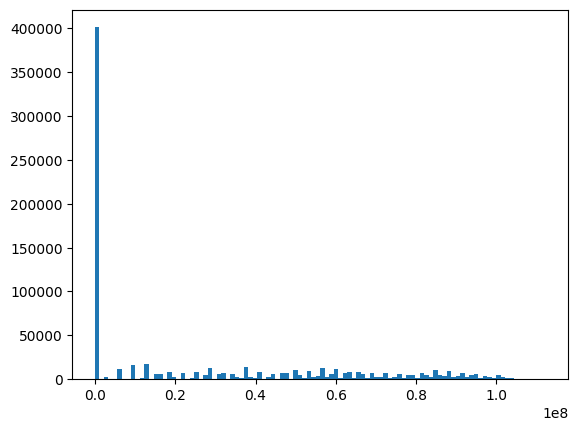

In [ ]:
import matplotlib.pyplot as plt
_ = plt.hist(OUT.data.numpy().flatten(),bins=100)